In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
import xlrd
import json
import asposecells     


In [2]:
## pandas 출력 옵션 설정, 최대 출력 행 열 

pd.set_option('display.max_rows',50)
pd.set_option('display.max_columns',50)

In [3]:
result_files = glob.glob(os.path.join(f'{os.getcwd()}\\Report\\', 'V-EP6*_*.xls')) ## V-EP6으로 시작되는 파일 모두 확인
result_files.sort()
result_files

['d:\\MHC\\2023\\개인자료\\kmong\\조금예민한 독수리\\Report\\V-EP6XA197AA_20230321_122611_Fail_1.xls',
 'd:\\MHC\\2023\\개인자료\\kmong\\조금예민한 독수리\\Report\\V-EP6XA197AA_20230321_122642_Fail_2.xls',
 'd:\\MHC\\2023\\개인자료\\kmong\\조금예민한 독수리\\Report\\V-EP6XA197AA_20230321_122740_Fail_3.xls',
 'd:\\MHC\\2023\\개인자료\\kmong\\조금예민한 독수리\\Report\\V-EP6XA197AA_20230321_123338_Fail_4.xls',
 'd:\\MHC\\2023\\개인자료\\kmong\\조금예민한 독수리\\Report\\V-EP6XA197AA_20230324_120154_325.xls',
 'd:\\MHC\\2023\\개인자료\\kmong\\조금예민한 독수리\\Report\\V-EP6XA197AA_20230324_120227_326.xls',
 'd:\\MHC\\2023\\개인자료\\kmong\\조금예민한 독수리\\Report\\V-EP6XA197AA_20230324_120248_Fail_35.xls',
 'd:\\MHC\\2023\\개인자료\\kmong\\조금예민한 독수리\\Report\\V-EP6XA197AA_20230324_120307_Fail_36.xls',
 'd:\\MHC\\2023\\개인자료\\kmong\\조금예민한 독수리\\Report\\V-EP6XA197AA_20230324_120332_327.xls',
 'd:\\MHC\\2023\\개인자료\\kmong\\조금예민한 독수리\\Report\\V-EP6XA197AA_20230324_120354_328.xls',
 'd:\\MHC\\2023\\개인자료\\kmong\\조금예민한 독수리\\Report\\V-EP6XA197AA_20230324_120519_329.xls',
 'd:\\MHC\\2

In [4]:
len(result_files)

7053

In [5]:
## 485 type 과 ttl type의 각각 유효한 column의 list

valid_485 = ["AC 220V 전원 인가","AC 220V 전원 검사", "DC12V 전원 검사", "DC 5V 전원 검사", 
             "TEST 시작", "COM0 MODE 485", "H/W MODEL","F/W VERSION","UNIT TYPE", "EEPROM CHECK", "COM0 TEST", "COM1 TEST", 
             "SENSOR0 (TRA)", "SENSOR1 (TDF)", "RELAY0 COMP ON", "RELAY0 COMP OFF", "RELAY1 ALARM ON", "RELAY1 ALARM OFF"
             "RELAY2 DEF ON", "RELAY2 DEF OFF", "RELAY3 FAN ON", 'RELAY3 FAN OFF', "DISP MOSI HIGH", "DISP MOSI LOW", "DISP MISO HIGH",
             "DISP MISO LOW", "DISP CLK HIGH", "DISP CLK LOW", "DISP STB HIGH", "DISP STB LOW", "AC 220V 전원 OFF"]

valid_ttl = ["AC 220V 전원 인가","AC 220V 전원 검사", "DC12V 전원 검사", "DC 5V 전원 검사", 
           "TEST 시작", "COM0 MODE TTL", "H/W MODEL","F/W VERSION","UNIT TYPE", "EEPROM CHECK", "COM0 TEST", "COM1 TEST", 
           "SENSOR0 (TRA)", "SENSOR1 (TDF)", "RELAY0 COMP ON", "RELAY0 COMP OFF", "RELAY2 DEF ON", "RELAY2 DEF OFF",
           "RELAY3 FAN ON", 'RELAY3 FAN OFF', "DISP MOSI HIGH", "DISP MOSI LOW", "DISP MISO HIGH",
           "DISP MISO LOW", "DISP CLK HIGH", "DISP CLK LOW", "DISP STB HIGH", "DISP STB LOW", "COM0 TXEN HIGH", "COM0 TXEN LOW" "AC 220V 전원 OFF"]



In [16]:
# xls 파일을 통해 특정 영역내 데이터를 갖고온다.
import win32com.client

# 각 통신 타입 별로 data 불러와진 횟수를 카운트하기 위한 변수
type1, type2 = 0, 0

for f in result_files:
    info = f.split('\\')[-1].split('_') # date와 수량 정보를 파일 이름에서 추출한다.
    date, qty = info[1], info[2]
    excel = win32com.client.Dispatch("Excel.Application")
    workbook = excel.Workbooks.Open(f)

    # 시트 가져오기
    sheet = workbook.Sheets[0]

    # 데이터 가져오기
    data = sheet.Range("A1:G40").Value

    # 갖고온 데이터 dataframe 형태로 만들기
    df = pd.DataFrame(data)

    # dataframe column을 dataframe내 첫번째 행의 값으로 설정해주기
    df = df.rename(columns = df.iloc[0])

    # dataframe index 초기화 -> 0부터 순차적으로 설정
    df = df.drop(df.index[0]).reset_index(drop=True)

    # 데이터내 특정 검사항목을 통해 com type을 추출한다.
    com_type = df[(df['명령어']==8) |(df['명령어']==9)]['검사항목'].values[0]

    # 오류가 발생한 검사항목의 불량 내용을 추출하고, 정상적으로 끝난다면 OK값을 부여한다.
    if 'Fail(실패)' in list(df['OK 상태 확인'].values):
        fail_reason = df[df['OK 상태 확인']=='Fail(실패)']['불량내용'].values[0]
    else:
        fail_reason = 'OK'

    # 485 type의 통신이라면,
    if '485' in com_type:
        # 위에서 설정한 유효 컬럼들만 추출한다.
        df_485 = df[df['검사항목'].isin(valid_485)]
        if type1 ==0:

            # 초기 각 검사별로 ucl lcl 정보를 추출한다.
            # 검사항목을 key, 상한, 하한 값을 value로 dict를 구성한다.
            limit_485 = dict()
            for v in df_485[['검사항목', '측정 DATA1 상한', '측정 DATA1 하한']].values:
                ins, usl, lsl = v
                limit_485[ins]= dict()
                limit_485[ins]['usl'] = usl
                limit_485[ins]['lsl'] = lsl

        # 원본 data는 수치가 세로로 한행씩 수집됐으므로, Transpose 하여 가로축으로 각 검사별로 구분되도록 한다.
        df_485 = pd.DataFrame(df_485[['측정 DATA1']].values.T, columns=df_485.검사항목.values)
        # 특정 검사 시점의 date, qty 추가
        df_485['date'] = date 
        df_485['qty'] = qty
        # column 위치 조정
        new_cols = ['date', 'qty'] + list(df_485.columns)
        df_485 = df_485[new_cols]

        # com0 Mode의 값이 모두 Nan 이므로 통신 검사 오류일 경우 값을 0로 아닐경우 1 로 정정한다.
        if fail_reason == '0:실패, 1:성공':
            df_485['COM0 MODE 485'] = 0
        else:
            df_485['COM0 MODE 485'] = 1
        # 실패 원인을 파악할 수 있는 컬럼 생성
        df_485['Status'] = fail_reason
        # 각 파일 별로 하나씩 위의 수행한 값을 차례로 쌓는다.
        df_type1 = df_485 if type1 ==0 else pd.concat([df_type1, df_485], axis=0)
        type1 +=1

    # TTL의 경우도 위와 같다.
    elif 'TTL' in com_type:
        df_ttl = df[df['검사항목'].isin(valid_ttl)]
        if type2 ==0:
            limit_ttl = dict()
            for v in df_ttl[['검사항목', '측정 DATA1 상한', '측정 DATA1 하한']].values:
                ins, usl, lsl = v
                limit_ttl[ins]= dict()
                limit_ttl[ins]['usl'] = usl
                limit_ttl[ins]['lsl'] = lsl
        df_ttl = pd.DataFrame(df_ttl[['측정 DATA1']].values.T, columns=df_ttl.검사항목.values)
        df_ttl['date'] = date
        df_ttl['qty'] = qty
        new_cols = ['date', 'qty'] + list(df_ttl.columns)
        df_ttl = df_ttl[new_cols]
        if fail_reason == '0:실패, 1:성공':
            df_ttl['COM0 MODE TTL'] = 0
        else:
            df_485['COM0 MODE TTL'] = 1
        df_ttl['Status'] = fail_reason
        df_type2 = df_ttl if type2 ==0 else pd.concat([df_type2, df_ttl], axis=0)
        type2 +=1

    workbook.Close()
    excel.Quit()
    if type2==1:
        sys.exit()

SystemExit: 

d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [66]:
# 위의 485 통신 취합 파일을 저장한다.
df_type1.to_csv('com_485.csv', index=False)

In [67]:
# 위의 ttl 통신 취합 파일을 저장한다.
df_type2.to_csv('com_ttl.csv', index=False)

In [17]:
# 위에서 ttl 통신 검사항목들의 상하한 수치를 저장한 dict를 json 파일로 저장한다.
with open("limit_ttl.json", "w",encoding='utf-8') as outfile:
    json.dump(limit_ttl, outfile, indent='\t',ensure_ascii=False)

In [19]:
# 위에서 485 통신 검사항목들의 상하한 수치를 저장한 dict를 json 파일로 저장한다.
with open("limit_485.json", "w",encoding='utf-8') as outfile:
    json.dump(limit_485, outfile,indent='\t',ensure_ascii=False)

In [20]:
# 저장된 ttl 통신 검사항목들의 상하한 json 파일을 불러온다.
with open("limit_ttl.json", 'r', encoding='utf-8') as file:
    limt_ttl = json.load(file)
    print(type(limt_ttl))
    print(limt_ttl)


<class 'dict'>
{'AC 220V 전원 인가': {'usl': 0.0, 'lsl': 0.0}, 'AC 220V 전원 검사': {'usl': 230.0, 'lsl': 210.0}, 'DC12V 전원 검사': {'usl': 12.36, 'lsl': 11.64}, 'DC 5V 전원 검사': {'usl': 5.15, 'lsl': 4.85}, 'TEST 시작': {'usl': 1.0, 'lsl': 1.0}, 'COM0 MODE TTL': {'usl': 1.0, 'lsl': 1.0}, 'H/W MODEL': {'usl': 16.0, 'lsl': 16.0}, 'F/W VERSION': {'usl': 0.46, 'lsl': 0.46}, 'UNIT TYPE': {'usl': 1.0, 'lsl': 1.0}, 'EEPROM CHECK': {'usl': 1.0, 'lsl': 1.0}, 'COM0 TEST': {'usl': 1.0, 'lsl': 1.0}, 'COM1 TEST': {'usl': 1.0, 'lsl': 1.0}, 'SENSOR0 (TRA)': {'usl': 3.3, 'lsl': 2.8}, 'SENSOR1 (TDF)': {'usl': 3.5, 'lsl': 3.1}, 'RELAY0 COMP ON': {'usl': 1.0, 'lsl': 1.0}, 'RELAY0 COMP OFF': {'usl': 0.0, 'lsl': 0.0}, 'RELAY2 DEF ON': {'usl': 1.0, 'lsl': 1.0}, 'RELAY2 DEF OFF': {'usl': 0.0, 'lsl': 0.0}, 'RELAY3 FAN ON': {'usl': 1.0, 'lsl': 1.0}, 'RELAY3 FAN OFF': {'usl': 0.0, 'lsl': 0.0}, 'DISP MOSI HIGH': {'usl': 5.15, 'lsl': 4.85}, 'DISP MOSI LOW': {'usl': 0.15, 'lsl': 0.0}, 'DISP MISO HIGH': {'usl': 5.15, 'lsl': 4.85}

In [93]:

df_type1.reset_index(drop=True, inplace=True)
df_type2.reset_index(drop=True, inplace=True)

In [100]:
df_type1[df_type1['Status']=='0:실패, 1:성공']

date     qty AC 220V 전원 인가 AC 220V 전원 검사 DC12V 전원 검사 DC 5V 전원 검사  \
42  20230322  102431          None         221.4       12.02        5.06   

   TEST 시작  COM0 MODE 485 H/W MODEL F/W VERSION UNIT TYPE EEPROM CHECK  \
42     1.0              0      None        None      None         None   

   COM0 TEST COM1 TEST SENSOR0 (TRA) SENSOR1 (TDF) RELAY0 COMP ON  \
42      None      None          None          None           None   

   RELAY0 COMP OFF RELAY1 ALARM ON RELAY2 DEF OFF RELAY3 FAN ON  \
42            None            None           None          None   

   RELAY3 FAN OFF DISP MOSI HIGH DISP MOSI LOW DISP MISO HIGH DISP MISO LOW  \
42           None           None          None           None          None   

   DISP CLK HIGH DISP CLK LOW DISP STB HIGH DISP STB LOW AC 220V 전원 OFF  \
42          None         None          None         None           None   

        date     qty      Status  
42  20230322  102431  0:실패, 1:성공

In [21]:
## ttl 통신의 항목이 많으므로 ttl 유형으로 실험 진행함.
df = pd.read_csv('com_ttl.csv')

df

date     qty  AC 220V 전원 인가  AC 220V 전원 검사  DC12V 전원 검사  \
0     20230215   93936            NaN          218.5        12.03   
1     20230215   94008            NaN          219.2        12.03   
2     20230215   94133            NaN          218.6        12.01   
3     20230215   94206            NaN          218.7        12.03   
4     20230215   94240            NaN          218.3        12.00   
...        ...     ...            ...            ...          ...   
6182  20230215  113530            NaN          219.3        12.01   
6183  20230215  113548            NaN          219.6        12.02   
6184  20230215  113827            NaN          219.5        12.02   
6185  20230215  113847            NaN          219.1        12.02   
6186  20230215  114544            NaN          219.4        12.02   

      DC 5V 전원 검사  TEST 시작  COM0 MODE TTL  H/W MODEL  F/W VERSION  UNIT TYPE  \
0            5.07      1.0            NaN       16.0         0.46        1.0   
1            5.05      1.0            NaN       16.0         0.46        1.0   
2            5.04      1.0            NaN       16.0         0.46        1.0   
3            5.11      1.0            NaN       16.0         0.46        1.0   
4            5.06      1.0            NaN       16.0         0.46        1.0   
...           ...      ...            ...        ...          ...        ...   
6182         5.08      1.0            NaN       16.0         0.46        3.0   
6183         5.07      NaN            NaN        NaN          NaN        NaN   
6184         5.06      1.0            NaN       16.0         0.45        NaN   
6185         5.06      1.0            NaN       16.0         0.45        NaN   
6186         5.07      1.0            NaN       16.0         0.46        3.0   

      EEPROM CHECK  COM0 TEST  COM1 TEST  SENSOR0 (TRA)  SENSOR1 (TDF)  \
0              1.0        1.0        1.0           3.12           3.33   
1              1.0        1.0        1.0           3.11           3.33   
2              1.0        1.0        1.0           3.12           3.33   
3              1.0        1.0        1.0           3.12           3.34   
4              1.0        1.0        1.0           3.12           3.34   
...            ...        ...        ...            ...            ...   
6182           1.0        1.0        1.0           3.12           3.33   
6183           NaN        NaN        NaN            NaN            NaN   
6184           NaN        NaN        NaN            NaN            NaN   
6185           NaN        NaN        NaN            NaN            NaN   
6186           1.0        1.0        1.0           3.12           3.32   

      RELAY0 COMP ON  RELAY0 COMP OFF  RELAY2 DEF ON  RELAY2 DEF OFF  \
0                1.0              0.0            1.0             0.0   
1                1.0              0.0            1.0             0.0   
2                1.0              0.0            1.0             0.0   
3                1.0              0.0            1.0             0.0   
4                1.0              0.0            1.0             0.0   
...              ...              ...            ...             ...   
6182             1.0              0.0            1.0             0.0   
6183             NaN              NaN            NaN             NaN   
6184             NaN              NaN            NaN             NaN   
6185             NaN              NaN            NaN             NaN   
6186             1.0              0.0            1.0             0.0   

      RELAY3 FAN ON  RELAY3 FAN OFF  DISP MOSI HIGH  DISP MOSI LOW  \
0               1.0             0.0            0.00            NaN   
1               1.0             0.0            5.12            0.0   
2               1.0             0.0            5.12            0.0   
3               1.0             0.0            5.12            0.0   
4               1.0             0.0            5.12            0.0   
...             ...             ...           

In [22]:
df.Status.value_counts()

OK                                                                    4943
JP1.1                                                                  374
CN9.3, DC전압 검출                                                         249
0 : NO TEST 1 : TEST 진행중 2 : TEST 완료                                   202
K1.1                                                                   108
CN9.4, DC전압 검출                                                          27
CN5.1(19.8KΩ), 3.046Volt                                                13
CN2.7, AC전압 검출                                                          13
U2.8, DC전압 검출                                                           12
CN9.6, DC전압 검출                                                          11
0:X(x)1A, 2:X(x)1C, 4:X(x)1E1:X(x)2B, 3:X(x)2D, 5:X(x)2F, 6:X(x)2G       8
CN9.5, DC전압 검출                                                           7
CN6.1(25.2KΩ), 3.328Volt                                                 6
CN2.5, AC전압 검출           

In [23]:
df.Status.isna().sum()

205

In [24]:

# 검사 Status가 Nan인 경우는 drop 한다.
df.dropna(subset=['Status'],axis=0, inplace=True)

In [25]:
# TTL satus가 위 작업에서 제대로 수행되지 않았는지, nan 만 확인됨.
df['COM0 MODE TTL'].unique()

array([nan])

In [26]:
# Status 가 통신 검사 앞에서 끝난 항목들은 모두 통신 검사항목을 0으로 채움

df.loc[df[(df['Status']=='CN3')|(df['Status']=='K1.1')|(df['Status']=='JP1.1')|(df['Status']=='0 : NO TEST 1 : TEST 진행중 2 : TEST 완료 ')].index, 'COM0 MODE TTL']=0

In [27]:
# 그 외 건은 모두 1로 정상 검사로 설정해줌.
df['COM0 MODE TTL'].fillna(1, inplace=True)

In [28]:
df['COM0 MODE TTL'].unique()

array([1., 0.])

In [29]:
# 쓸모없는 컬럼 삭제
df.drop(['date.1','qty.1'], axis=1, inplace=True)

In [30]:
df.Status.unique()

array(['CN9.3, DC전압 검출', 'OK', '0 : NO TEST 1 : TEST 진행중 2 : TEST 완료 ',
       'JP1.1', 'CN5.1(19.8KΩ), 3.046Volt', 'CN2.7, AC전압 검출',
       'CN9.4, DC전압 검출',
       '0:X(x)1A, 2:X(x)1C, 4:X(x)1E1:X(x)2B, 3:X(x)2D, 5:X(x)2F, 6:X(x)2G',
       'CN9.5, DC전압 검출', 'CN9.6, DC전압 검출', 'CN6.1(25.2KΩ), 3.328Volt',
       'K1.1', 'U2.8, DC전압 검출', 'CN2.5, AC전압 검출', 'CN3',
       '표현방법( #.## ) , (0:0.00 , 255:2.55)'], dtype=object)

In [31]:
# 각 공정 검사시 numeric value만 추출하기 위함.
numeric = ['DC12V 전원 검사', 'DC 5V 전원 검사', 'SENSOR0 (TRA)', 
           'SENSOR1 (TDF)', 'DISP MOSI HIGH', 'DISP MISO HIGH', 'DISP CLK HIGH', 'DISP STB HIGH']
           
# 각 numeric 검사항목들의 불량명
defect = ['K1.1','JP1.1','CN5.1(19.8KΩ), 3.046Volt', 'CN6.1(25.2KΩ), 3.328Volt', 'CN9.3, DC전압 검출', 'CN9.4, DC전압 검출', 'CN9.5, DC전압 검출', 'CN9.6, DC전압 검출']

In [32]:
# 각 검사 별로 별도의 data frame을 구성한다.
# dict에 key를 공정검사 명, value를 dataframe 으로 구성한다.
df_list = dict()

for n, d in zip(numeric, defect):
    df_list[n] = pd.DataFrame(df[(df['Status']==d) | (df['Status']=='OK')][['date','qty',n, 'Status']]).reset_index(drop=True)

In [33]:
df_list

{'DC12V 전원 검사':           date     qty  DC12V 전원 검사 Status
 0     20230215   94008        12.03     OK
 1     20230215   94133        12.01     OK
 2     20230215   94206        12.03     OK
 3     20230215   94240        12.00     OK
 4     20230215   94332        12.02     OK
 ...        ...     ...          ...    ...
 5046  20230215  113357        12.11     OK
 5047  20230215  113424        12.03     OK
 5048  20230215  113455        12.03     OK
 5049  20230215  113530        12.01     OK
 5050  20230215  114544        12.02     OK
 
 [5051 rows x 4 columns],
 'DC 5V 전원 검사':           date     qty  DC 5V 전원 검사 Status
 0     20230215   94008         5.05     OK
 1     20230215   94133         5.04     OK
 2     20230215   94206         5.11     OK
 3     20230215   94240         5.06     OK
 4     20230215   94332         5.07     OK
 ...        ...     ...          ...    ...
 5312  20230215  113424         5.04     OK
 5313  20230215  113455         5.08     OK
 5314  20230215  1

In [34]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.family'] ='Malgun Gothic'

matplotlib.rcParams['axes.unicode_minus'] =False

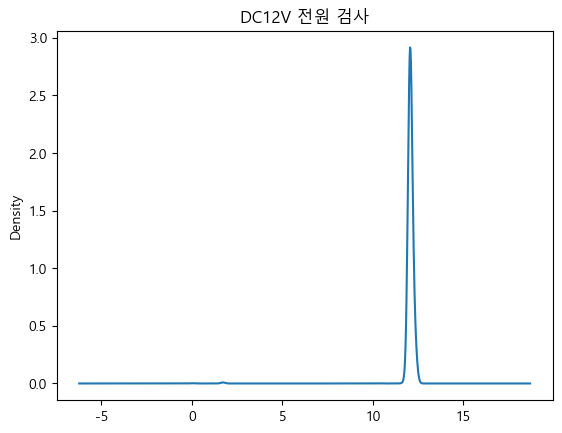

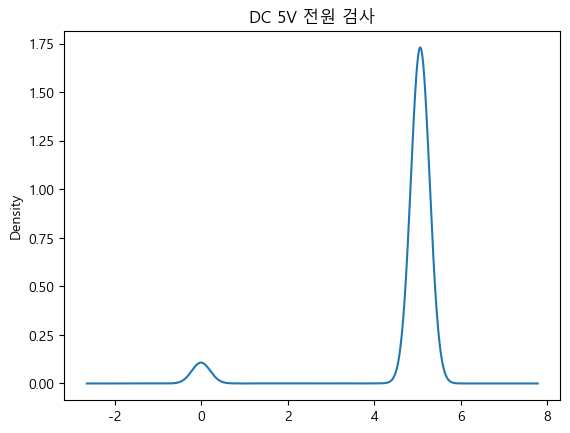

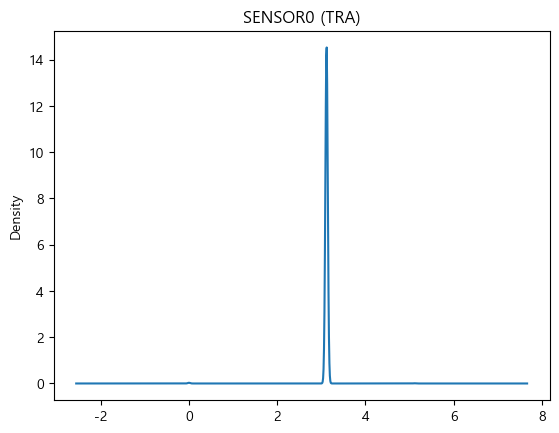

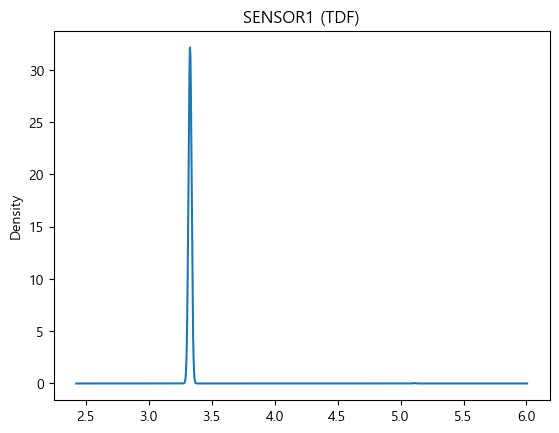

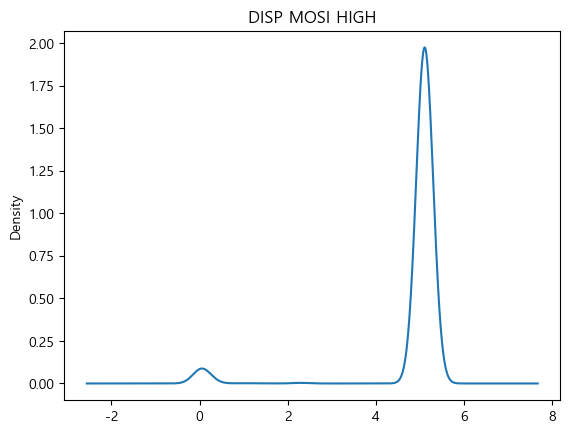

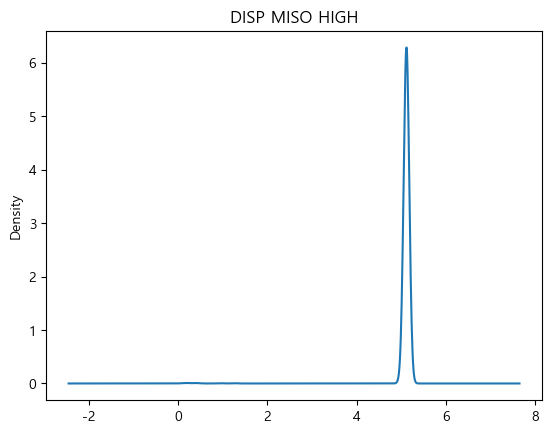

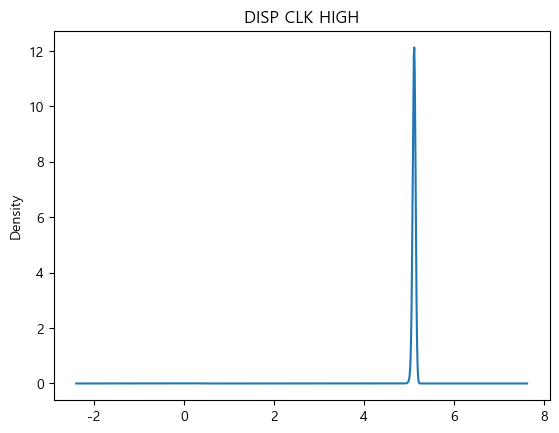

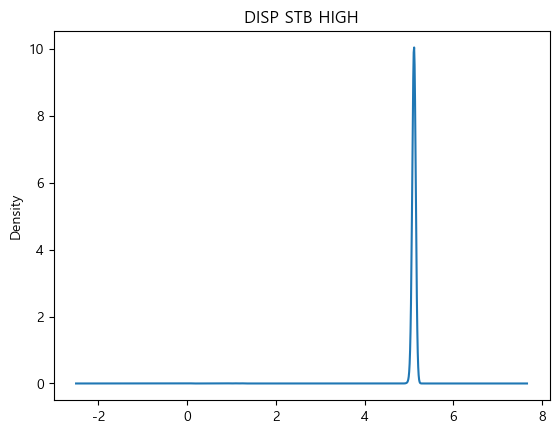

In [35]:
# 각 검사 항목들의 density plot을 그려서 각 수치들의 분포를 시각적으로 확인한다.

for k, v in df_list.items():
    plt.figure()
    v[k].plot(kind='density')
    plt.title(k)
    plt.show()


In [36]:
from scipy.stats import kstest, normaltest, shapiro, anderson

# box plot을 통한 outlier 파악하기 위한 함수 구성
def boxplot_whiskers(x):
    plt.figure()
    boxplot = plt.boxplot(x)
    boxplot_whiskers = [item.get_ydata() for item in boxplot['whiskers']]
    return(boxplot_whiskers)

def outlier_check(x):
    y = boxplot_whiskers(x)
    print(np.min(y), np.max(y))
    # 3sigma 확인
    sigma_3_p = np.mean(x) + 3*np.std(x) 
    sigma_3_m = np.mean(x) - 3*np.std(x)
    print('3 sigma range :',sigma_3_m, sigma_3_p)
    out_idx = np.where(x>=sigma_3_p)[0]
    out_values = x[out_idx]
    plt.figure()
    boxplot = plt.boxplot(x[-out_idx])
    return(pd.DataFrame({'outlier_index': out_idx,'outliers': out_values}))


## 'DC12V 전원 검사'

In [37]:
# 위에서 구성한 dict에서 DC12V 전원 검사 dataframe을 불러온다.
dc_12 = df_list['DC12V 전원 검사']

# 해당 검사항목에는 불량값에 대한 nan이 있으므로, 각 불량들의 평균수치로 nan을 대체한다.
na_v = dc_12[dc_12['Status']!='OK']['DC12V 전원 검사'].mean()
dc_12['DC12V 전원 검사'].fillna(na_v,inplace = True)


In [38]:
# 공정 통계 정규성 검정 , shapiro wilk, ks test, normality test 를 통해 검정함.
# 정규분포를 따른다면 SPC(statistical process control)을 사용하는 것이 매우 합당하므로 검정이 필요함.
# 하지만 해당 검정으로 정규성이 아니라고 해서 SPC를 사용할 수 없는 것이 아님. 위에서 확인한 density plot에서 유사 정규분포로 확인된다면, spc활용이 가능
# 단지 spc를 사용할 수 있다는 명확한 명분을 제공하기 위해 정규성 검정을 실시하는 것.
test_stat, p_val = shapiro(dc_12['DC12V 전원 검사'])
ks_stat, p_valks = kstest(dc_12['DC12V 전원 검사'], 'norm')
nm_stat, p_valnm = normaltest(dc_12['DC12V 전원 검사'])

print("SHAPIRO Result : test-statistics : {}, p-value : {}".format(test_stat, p_val))
print("KS Result : test-statistics : {}, p-value : {}".format(ks_stat, p_valks))
print("Normal Result : test-statistics : {}, p-value : {}".format(nm_stat, p_valnm))

test_res1 = anderson(dc_12['DC12V 전원 검사'], dist = 'norm')
print(test_res1)


SHAPIRO Result : test-statistics : 0.09887492656707764, p-value : 0.0
KS Result : test-statistics : 0.9968323104335776, p-value : 0.0
Normal Result : test-statistics : 10255.335529749633, p-value : 0.0
AndersonResult(statistic=1390.718400341374, critical_values=array([0.576, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


통계검정 해석 :
P-value < 0.05 이므로 해당 data는 정규분포를 따른다는 귀무 가설을 기각할 수 있습니다.

11.91 12.23
3 sigma range : 10.219834494193814 13.886506361785477


Empty DataFrame
Columns: [outlier_index, outliers]
Index: []

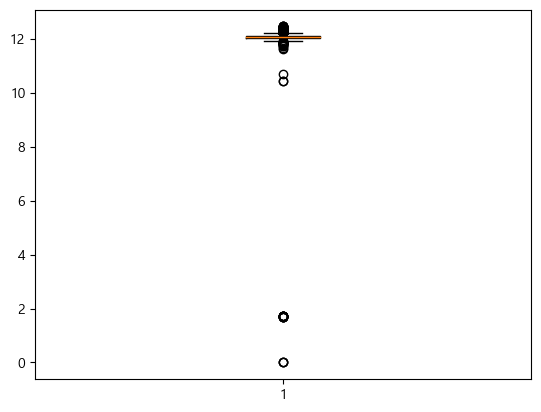

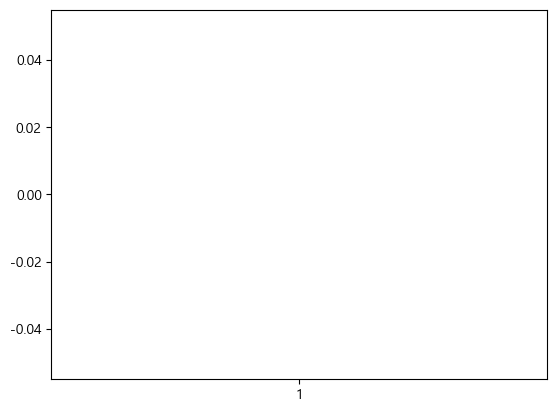

In [39]:

outlier_check(dc_12['DC12V 전원 검사'].values)

In [40]:
process = 'DC12V 전원 검사'

In [41]:
# 해당 검사의 평균, std를 구한다.
mean = dc_12[process].mean()
std = dc_12[process].std()

In [42]:

# 3sigma 밖의 수치들은 제외하고 정상이라고 가정된 항목만 추림
test_des = dc_12[(dc_12[process] < (mean+(3*std))) & (dc_12[process] > (mean-(3*std)))][process].describe()
display(test_des)
test_des['mean']

count    5035.000000
mean       12.087067
std         0.102531
min        10.420000
25%        12.030000
50%        12.060000
75%        12.110000
max        12.460000
Name: DC12V 전원 검사, dtype: float64

12.087067295288124

In [43]:
# 정상치의 2~3 sigma를 control limit 
ucl, lcl = test_des['mean'] + (2*test_des['std']), test_des['mean'] - (3*test_des['std'])
usl, lsl = limt_ttl[process]['usl'], limt_ttl[process]['lsl']
print('spec limit:',usl, lsl)
print('control limit:',ucl, lcl)

spec limit: 12.36 11.64
control limit: 12.29212871235993 11.779475169680417


In [44]:
test_df_c = dc_12.copy()

# 관리 상/하한에 따라 anomal(이상) point를 찾아낸다. 
anomal_upper = test_df_c[test_df_c[process]>= ucl].index
anomal_under = test_df_c[test_df_c[process]<= lcl].index
# 이상치 여부를 확인하기위한 컬럼 생성하고 기본값은 0를 할당한다.
# upper 이상치면2, under 이상치면 1을 할당한다.
test_df_c['anomal_detection'] = 0
test_df_c.loc[anomal_upper, 'anomal_detection'] = 2
test_df_c.loc[anomal_under, 'anomal_detection'] =1
test_df_c.reset_index(drop=True, inplace=True)
display(test_df_c)

date     qty  DC12V 전원 검사 Status  anomal_detection
0     20230215   94008        12.03     OK                 0
1     20230215   94133        12.01     OK                 0
2     20230215   94206        12.03     OK                 0
3     20230215   94240        12.00     OK                 0
4     20230215   94332        12.02     OK                 0
...        ...     ...          ...    ...               ...
5046  20230215  113357        12.11     OK                 0
5047  20230215  113424        12.03     OK                 0
5048  20230215  113455        12.03     OK                 0
5049  20230215  113530        12.01     OK                 0
5050  20230215  114544        12.02     OK                 0

[5051 rows x 5 columns]

[0 0 0 ... 0 0 0]


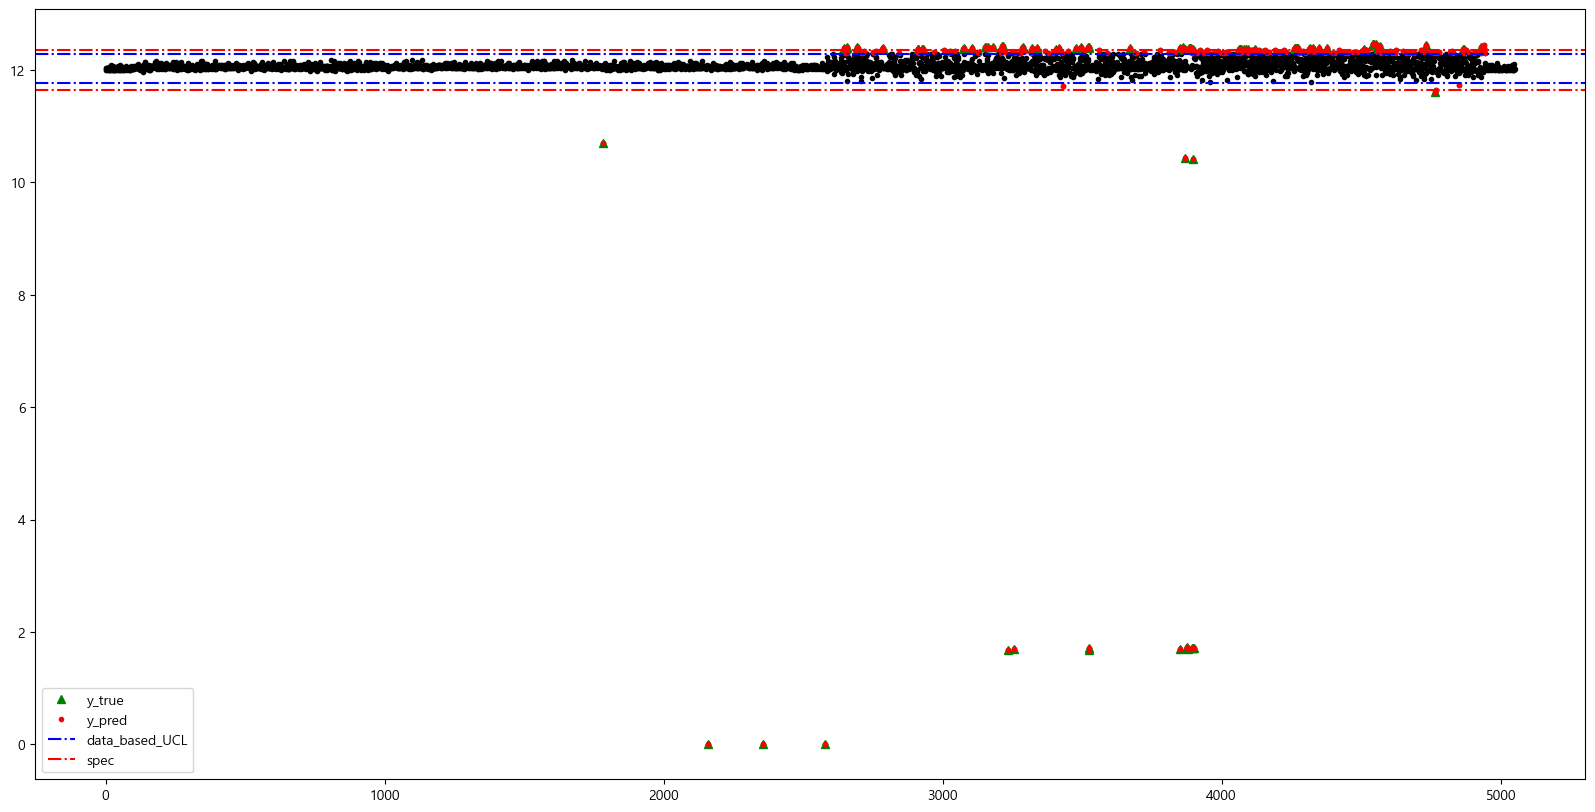

In [47]:

mask = test_df_c['anomal_detection'].values
print(mask)

# 0이 아닌 수치는 모두 이상치이므로 해당 index를 추출하고 이상 index는 붉은 색으로 표기한다.
# 이때 spec limt 은 붉은 색 점선, control limt 은 파란색 점선으로 그린다.
anom_idx = test_df_c[(test_df_c['anomal_detection'] != 0)].index
y_idx = test_df_c[(test_df_c['Status'] != 'OK')].index
plt.figure(figsize=(20,10))
plt.plot(test_df_c.loc[:,process], '.k')

plt.plot(test_df_c.loc[y_idx,process], '^', color='g', label='y_true')

plt.plot(test_df_c.loc[anom_idx,process], '.r', label ='y_pred')
plt.axhline(y=ucl, color='b', linestyle = '-.', label='data_based_UCL')
plt.axhline(y=lcl, color='b', linestyle = '-.')

plt.axhline(y=usl, color='r', linestyle = '-.', label = 'spec')
plt.axhline(y=lsl, color='r', linestyle = '-.')
plt.legend()
# plt.ylim([106, 114])